# Import Libraries

In [1]:
# Set seed for reproducibility

seed = 42

# Import necessary libraries

import os

# Import necessary modules

import logging

import random

import numpy as np

# Set environment variables before importing modules

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['PYTHONHASHSEED'] = str(seed)

os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=Warning)

# Import TensorFlow and Keras

import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl

# Set seeds for random number generators in NumPy and Python

np.random.seed(seed)

random.seed(seed)

# Set seed for TensorFlow

tf.random.set_seed(seed)

tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity

tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import seaborn as sns

from PIL import Image

import matplotlib.gridspec as gridspec

# Configure plot display settings

sns.set(font_scale=1.4)

sns.set_style('white')

plt.rc('font', size=14)

%matplotlib inline

# Load Data

In [ ]:
data = np.load('/kaggle/input/dataset/training_set.npz')

X = data['images']

y = data['labels'].flatten()

print("Training set caricato correttamente")

Training set caricato correttamente


# Inspect Data

Dimensione di X (immagini): (13759, 96, 96, 3)
Dimensione di y (etichette): (13759,)
Qualche immagine del dataset




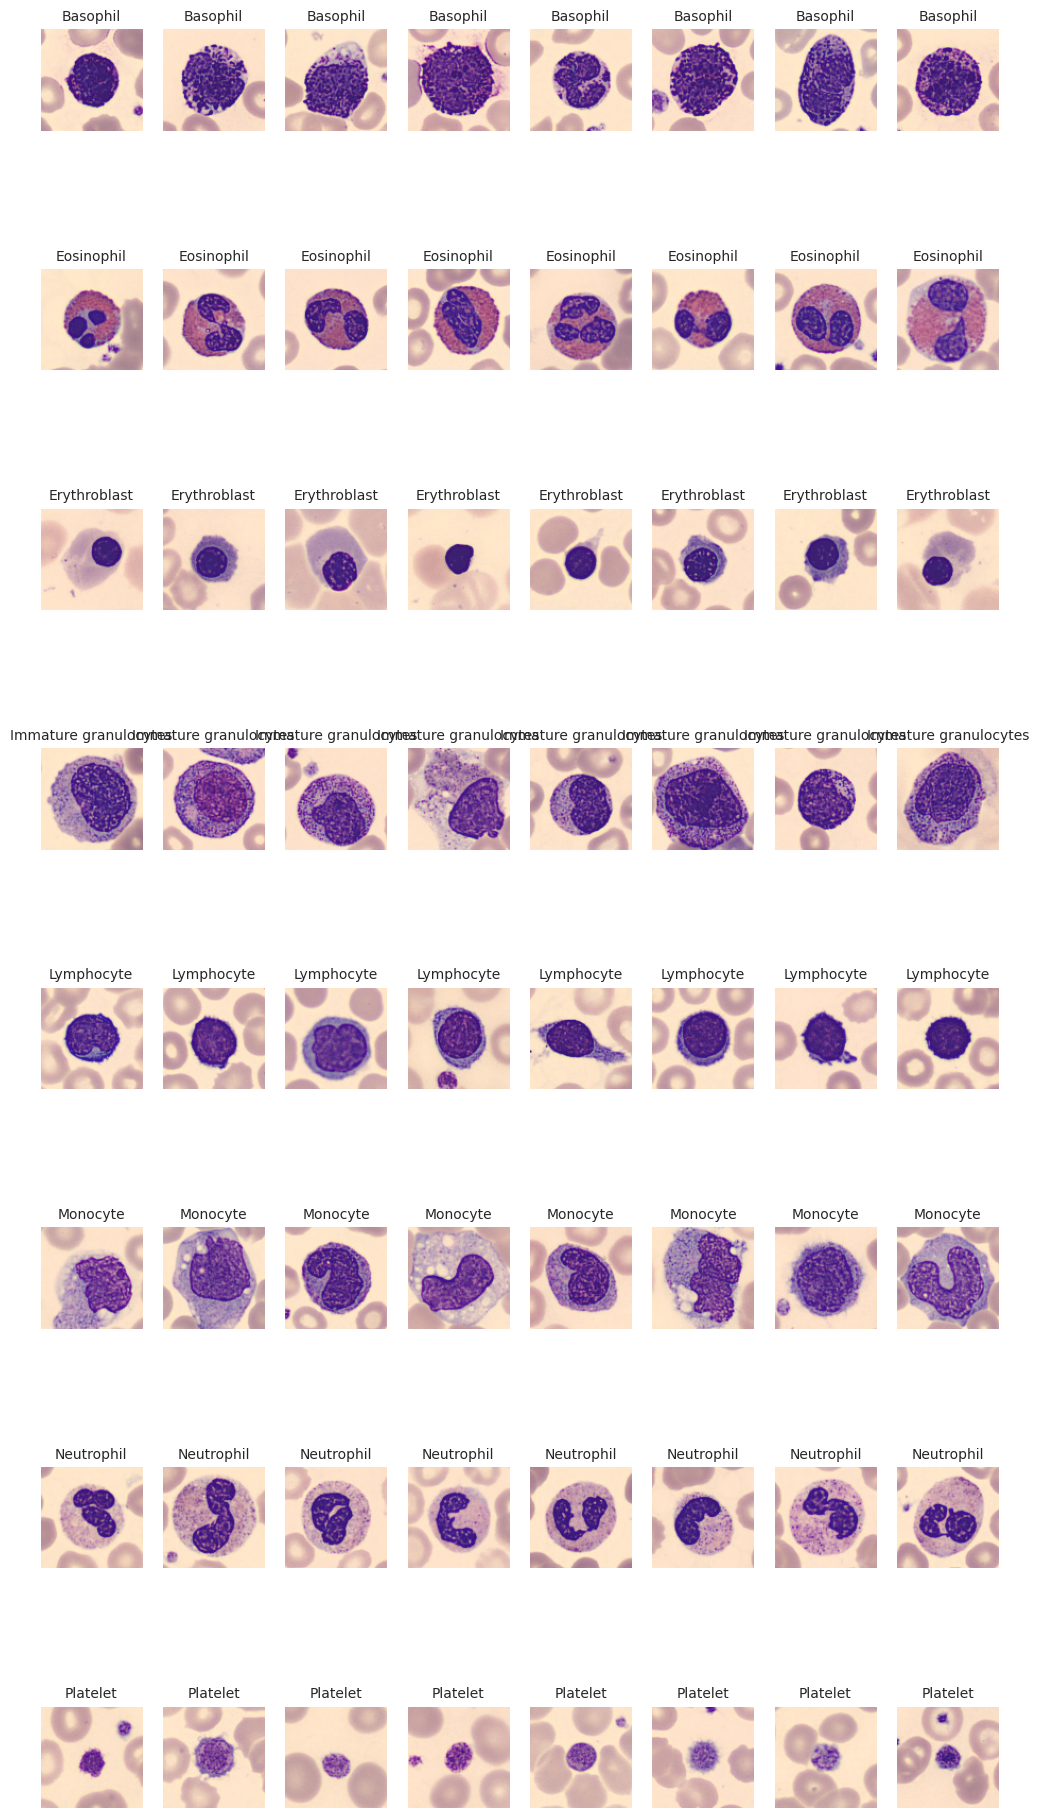

In [ ]:
# Stampa il numero di campioni e la dimensione di ogni campione

print("Dimensione di X (immagini):", X.shape)

print("Dimensione di y (etichette):", y.shape)


# Stampa di alcune immagini del dataset

print("Qualche immagine del dataset\n\n")

label_dict = {

    0: "Basophil",

    1: "Eosinophil",

    2: "Erythroblast",

    3: "Immature granulocytes",

    4: "Lymphocyte",

    5: "Monocyte",

    6: "Neutrophil",

    7: "Platelet"

}

num_img_per_label = 8

num_labels = len(label_dict)

fig, axes = plt.subplots(num_labels, num_img_per_label, figsize=(10, 20))

for label, label_name in label_dict.items():

    indices = np.where(y == label)[0]

    selected_indices = indices[:num_img_per_label]

    for i, idx in enumerate(selected_indices):

        ax = axes[label, i]

        ax.imshow(np.clip(X[idx], 0, 255), cmap='gray')

        ax.set_title(f"{label_name}", fontsize=10)

        ax.axis('off')

plt.tight_layout()

plt.show()

# Removing outliers

In [ ]:
# Funzione per rimuovere gli outliers

def remove_outliers(X, y, label_dict, num_img_per_label=5):

    outliers_removed = {label: 0 for label in label_dict}

    for label, label_name in label_dict.items():

        indices = np.where(y == label)[0]

        outlier_index = indices[-1]

        outlier_image = X[outlier_index]

        duplicate_indices = indices[np.all(X[indices] == outlier_image, axis=(1, 2, 3))]

        X = np.delete(X, duplicate_indices, axis=0)

        y = np.delete(y, duplicate_indices, axis=0)

        outliers_removed[label] += len(duplicate_indices)

    return X, y, outliers_removed

# Esegui la rimozione degli outliers

X_cleaned, y_cleaned, outliers_removed = remove_outliers(X, y, label_dict)

# Stampa il numero di outliers eliminati per le classi

print("Numero di outliers (tipo 1) eliminati per classe:")

for label, count in outliers_removed.items():

    print(f"{label_dict[label]}: {count} outlier/i eliminato/i")


X_cleaned, y_cleaned, outliers_removed = remove_outliers(X_cleaned, y_cleaned, {5: "Monocyte"})


# Stampa il numero di outliers eliminati per la classe 5

print("\nNumero di outliers (tipo 2) eliminati per classe:")

for label, count in outliers_removed.items():

    print(f"{label_dict[label]}: {count} outlier/i eliminato/i")


Numero di outliers (tipo 1) eliminati per classe:
Basophil: 200 outlier/i eliminato/i
Eosinophil: 200 outlier/i eliminato/i
Erythroblast: 200 outlier/i eliminato/i
Immature granulocytes: 200 outlier/i eliminato/i
Lymphocyte: 200 outlier/i eliminato/i
Monocyte: 200 outlier/i eliminato/i
Neutrophil: 200 outlier/i eliminato/i
Platelet: 200 outlier/i eliminato/i

Numero di outliers (tipo 2) eliminati per classe:
Monocyte: 200 outlier/i eliminato/i


In [ ]:
# Verifico che tutte le immagini abbiano la stessa size

unique_shapes = {img.shape for img in X}

if len(unique_shapes) == 1:

    print("Tutte le immagini hanno la stessa dimensione:", unique_shapes.pop())

else:

    print("Le immagini hanno dimensioni diverse. Ecco le dimensioni uniche:", unique_shapes)


# Calculate the unique target labels and their counts

unique, count = np.unique(y, return_counts=True)

print('Target labels:', unique)

for u in unique:

    print(f'Class {unique[u]} has {count[u]} samples')

Tutte le immagini hanno la stessa dimensione: (96, 96, 3)
Target labels: [0 1 2 3 4 5 6 7]
Class 0 has 1052 samples
Class 1 has 2381 samples
Class 2 has 1285 samples
Class 3 has 2226 samples
Class 4 has 1049 samples
Class 5 has 1393 samples
Class 6 has 2530 samples
Class 7 has 1843 samples


# Split in train and validation set

In [ ]:

# Impostazione del seed per la riproducibilità

seed = 42

num_classes = 8


X_train, X_val, y_train, y_val = train_test_split(

    X_cleaned, y_cleaned,

    test_size=0.15,

    random_state=seed,

    stratify=y_cleaned

)


# Verifica delle dimensioni dei set

print('Training set shape:\t', X_train.shape, y_train.shape)

print('Validation set shape:\t', X_val.shape, y_val.shape)


y_train = tfk.utils.to_categorical(y_train, num_classes=num_classes)

y_val = tfk.utils.to_categorical(y_val, num_classes=num_classes)

Training set shape:	 (10165, 96, 96, 3) (10165,)
Validation set shape:	 (1794, 96, 96, 3) (1794,)


In [ ]:
# Input shape for the model

input_shape = X_train.shape[1:]

# Output shape for the model

output_shape = y_train.shape[1]


print("Input Shape:", input_shape)

print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


# Define network parameters

In [ ]:
learning_rate = 0.00001


batch_size = 64


epochs = 100

# Augmentation and Input Preprocessing

In [ ]:
pip install keras-cv

Note: you may need to restart the kernel to use updated packages.


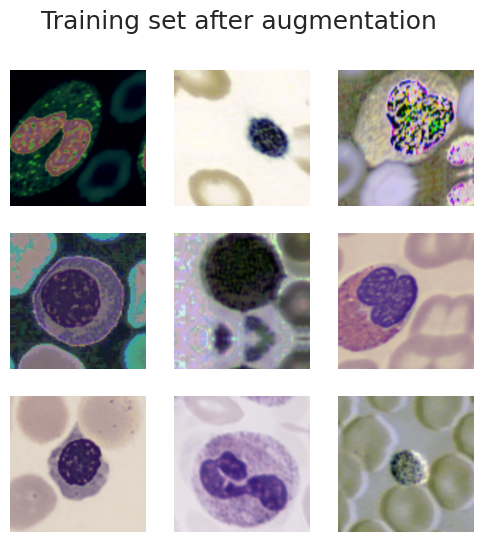

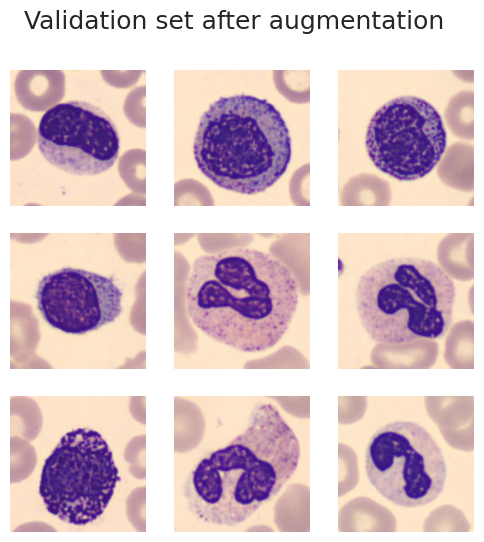

In [ ]:
import keras_cv

from tensorflow.keras.applications.efficientnet import preprocess_input


def to_dict(image, label):

    image = tf.image.convert_image_dtype(image, tf.float32)

    return {"images": image, "labels": label}



# Funzione di preprocessing per estrarre immagini e labels dal dictionary

def prep(inputs):

    images = inputs["images"]

    labels = inputs["labels"]

    images = tf.clip_by_value(images*255.0,0,255)

    images = tf.cast(images, tf.float32)

    images = preprocess_input(images)

    images = tf.image.resize(images, (380, 380))

    return images, labels



# Pipeline di Augmentation

augmentation_pipeline = tf.keras.Sequential([

    keras_cv.layers.AugMix(value_range=(0, 1.0), severity=0.2),

    keras_cv.layers.RandAugment(value_range=(0, 1.0), augmentations_per_image=2, magnitude=0.3)

], name='augmentation')



# Creazione del training dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = train_dataset.map(to_dict, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.batch(batch_size)

# Applica il pipeline di augmentation

train_dataset = train_dataset.map(lambda x: augmentation_pipeline(x), num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.map(prep, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(buffer_size=1024).prefetch(tf.data.AUTOTUNE)


# Creazione del validation dataset

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

val_dataset = val_dataset.map(to_dict, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.map(prep, num_parallel_calls=tf.data.AUTOTUNE)


# Visualizza alcune immagini del dataset dopo il preprocessing

def visualize_dataset(dataset, title):

    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)

    for i, samples in enumerate(iter(dataset.take(9))):

        images = samples[0]

        plt.subplot(3, 3, i + 1)

        plt.imshow(images[0].numpy().astype("uint8"))

        plt.axis("off")

    plt.show()


visualize_dataset(train_dataset, title=" Training set after augmentation")

visualize_dataset(val_dataset, title="Validation set after augmentation")

# Build the model

In [ ]:
input_shape = (380,380,3)

print("Input Shape:", input_shape)


effNet = tfk.applications.EfficientNetB4(

    input_shape=input_shape,

    include_top=False,

    weights='imagenet',

    pooling='avg'

)

# Freeze di tutti i layers in modo da utilizzare la rete come feature extractor

effNet.trainable = False


inputs = tfk.Input(shape=input_shape, name='input_layer')

# augmentation base

augmentation = tf.keras.Sequential([

    tfkl.RandomFlip("horizontal"),

    tfkl.RandomTranslation(0.2, 0.2)

], name='preprocessing')


x = augmentation(inputs)

x = effNet(x)


# Aggiunta di un dropout layer

x = tfkl.Dropout(0.3, name='dropout')(x)


# Aggiunta di un Dense layer finale

outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)


tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')


# Categorical cross-entropy loss and Lion optimizer

tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(learning_rate), metrics=['accuracy'])


tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters

#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Input Shape: (380, 380, 3)
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip (RandomFlip)   │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_translation_2       │ (None, 380, 380, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling (Rescaling)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ normalization              │ (None, 380, 380, 3)    │             7 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling_1 (Rescaling)    │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_conv_pad              │ (None, 381, 381, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_conv (Conv2D)         │ (None, 190, 190, 48)   │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_bn                    │ (None, 190, 190, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_activation            │ (None, 190, 190, 48)   │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_dwconv             │ (None, 190, 190, 48)   │           432 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_bn                 │ (None, 190, 190, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_activation         │ (None, 190, 190, 48)   │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_squeeze         │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_reshape         │ (None, 1, 1, 48)       │             0 │
│ (Reshape)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_reduce (Conv2D) │ (None, 1, 1, 12)       │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_expand (Conv2D) │ (None, 1, 1, 48)       │           62

 Total params: 17,688,167 (67.48 MB)

 Trainable params: 14,344 (56.03 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

# First Training - Feature Extractor

In [ ]:

tl_history = tl_model.fit(

    train_dataset,

    batch_size=batch_size,

    epochs= epochs,

    validation_data=val_dataset,

    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]

).history


final_val_accuracy = round(max(tl_history['val_accuracy']) * 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')


# Salvataggio del modello

model_filename = 'FuoriDiTesta_' + str(final_val_accuracy) + '.keras'

tl_model.save(model_filename)

del tl_model

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 218s 773ms/step - accuracy: 0.1508 - loss: 2.0828 - val_accuracy: 0.2269 - val_loss: 1.9202
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 193s 731ms/step - accuracy: 0.2193 - loss: 1.9763 - val_accuracy: 0.3266 - val_loss: 1.8288
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 194s 732ms/step - accuracy: 0.2776 - loss: 1.8913 - val_accuracy: 0.4025 - val_loss: 1.7355
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 192s 731ms/step - accuracy: 0.3278 - loss: 1.8240 - val_accuracy: 0.4889 - val_loss: 1.6465
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 193s 732ms/step - accuracy: 0.3742 - loss: 1.7438 - val_accuracy: 0.5368 - val_loss: 1.5673
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 194s 731ms/step - accuracy: 0.4067 - loss: 1.6933 - val_accuracy: 0.5602 - val_loss: 1.4958
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 193s 730ms/step - accuracy: 0.4287 - loss: 1.6442 - val_accuracy: 0.5836 - val_loss: 1.4301
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 192s 730ms/step - accuracy: 

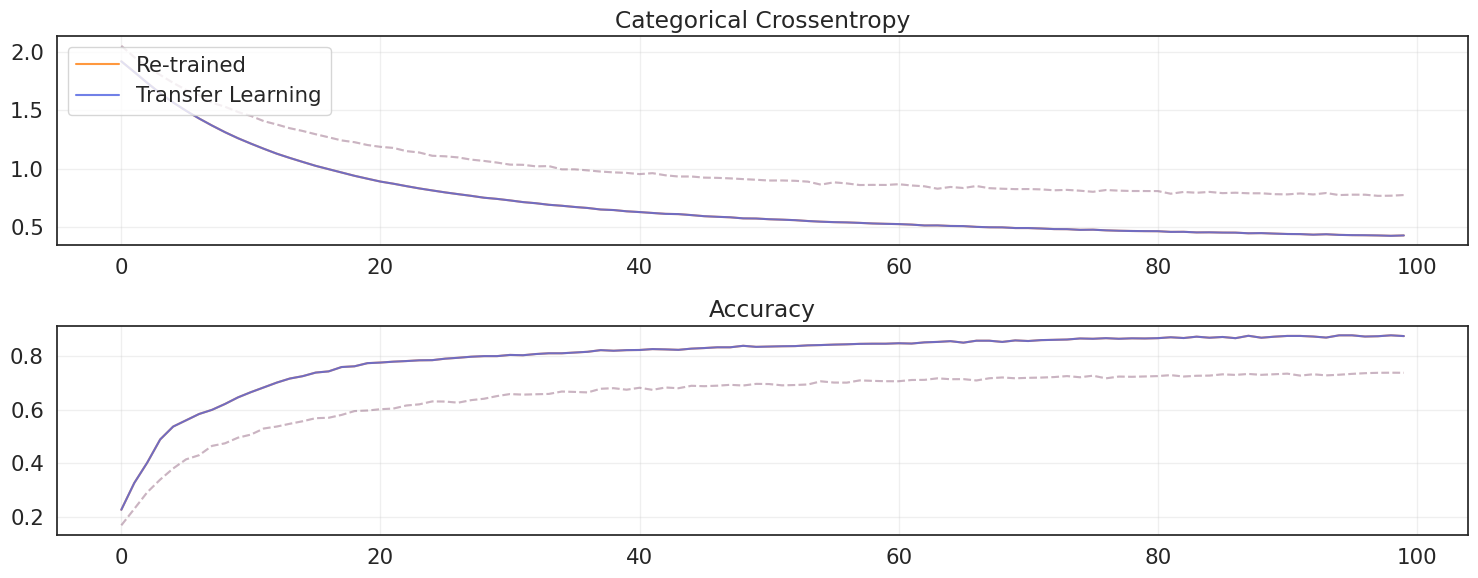

In [ ]:
# Plot dei risultati

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

ax1.plot(tl_history['loss'], alpha=0.3, color='#ff7f0e', linestyle='--')

ax1.plot(tl_history['val_loss'], label='Re-trained', alpha=0.8, color='#ff7f0e')

ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')

ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')

ax1.set_title('Categorical Crossentropy')

ax1.legend(loc='upper left')

ax1.grid(alpha=0.3)


ax2.plot(tl_history['accuracy'], alpha=0.3, color='#ff7f0e', linestyle='--')

ax2.plot(tl_history['val_accuracy'], label='Re-trained', alpha=0.8, color='#ff7f0e')

ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')

ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')

ax2.set_title('Accuracy')

ax2.grid(alpha=0.3)

plt.tight_layout()

plt.show()

# Second Training - Fine Tuning

In [ ]:
# Re-load del modello

ft_model = tfk.models.load_model(model_filename,safe_mode=False)

# Freeze di N layers

ft_model.get_layer('efficientnetb4').trainable = True


for layer in ft_model.get_layer('efficientnetb4').layers:

    layer.trainable = False


for i, layer in enumerate(ft_model.get_layer('efficientnetb4').layers):

    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):

        layer.trainable = True



# Numero di layers da freezare

N = 100


for i, layer in enumerate(ft_model.get_layer('efficientnetb4').layers[:N]):

    layer.trainable = False


ft_model.summary(expand_nested=True)

#tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(learning_rate), metrics=['accuracy'])


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing (Sequential)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip (RandomFlip)   │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_translation_2       │ (None, 380, 380, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling (Rescaling)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ normalization              │ (None, 380, 380, 3)    │             7 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling_1 (Rescaling)    │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_conv_pad              │ (None, 381, 381, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_conv (Conv2D)         │ (None, 190, 190, 48)   │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_bn                    │ (None, 190, 190, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_activation            │ (None, 190, 190, 48)   │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_dwconv             │ (None, 190, 190, 48)   │           432 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_bn                 │ (None, 190, 190, 48)   │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_activation         │ (None, 190, 190, 48)   │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_squeeze         │ (None, 48)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_reshape         │ (None, 1, 1, 48)       │             0 │
│ (Reshape)                       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_reduce (Conv2D) │ (None, 1, 1, 12)       │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_se_expand (Conv2D) │ (None, 1, 1, 48)       │           62

 Total params: 17,702,513 (67.53 MB)

 Trainable params: 17,355,240 (66.20 MB)

 Non-trainable params: 332,927 (1.27 MB)

 Optimizer params: 14,346 (56.04 KB)

In [ ]:
# Retrain del modello

ft_history = ft_model.fit(

    train_dataset,

    batch_size = batch_size,

    epochs = epochs,

    validation_data = val_dataset,

    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]

).history


final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')


model_filename = 'FuoriDiTesta_FT_'+str(final_val_accuracy)+'.keras'

ft_model.save(model_filename)

del ft_model

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 336s 1s/step - accuracy: 0.7926 - loss: 0.5979 - val_accuracy: 0.9465 - val_loss: 0.1483
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.9101 - loss: 0.2589 - val_accuracy: 0.9805 - val_loss: 0.0601
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.9336 - loss: 0.1849 - val_accuracy: 0.9866 - val_loss: 0.0419
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.9443 - loss: 0.1536 - val_accuracy: 0.9849 - val_loss: 0.0469
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.9517 - loss: 0.1381 - val_accuracy: 0.9872 - val_loss: 0.0429
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - accuracy: 0.9621 - loss: 0.1087 - val_accuracy: 0.9911 - val_loss: 0.0294
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.9647 - loss: 0.1025 - val_accuracy: 0.9889 - val_loss: 0.0359
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 304s 1s/step - accuracy: 0.9672 - loss: 0.0912 - 

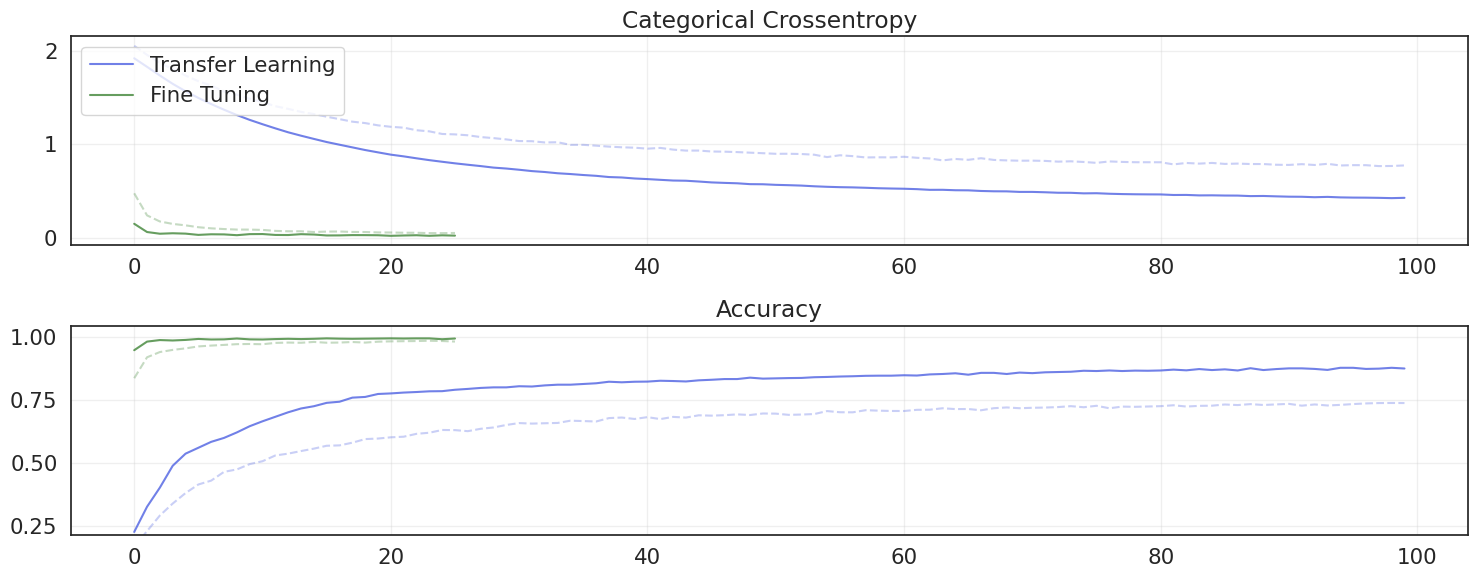

In [ ]:
# Plot dei risultati

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

ax1.plot(tl_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')

ax1.plot(tl_history['val_loss'], label='Transfer Learning', alpha=0.8, color='#4D61E2')

ax1.plot(ft_history['loss'], alpha=0.3, color='#408537', linestyle='--')

ax1.plot(ft_history['val_loss'], label='Fine Tuning', alpha=0.8, color='#408537')

ax1.set_title('Categorical Crossentropy')

ax1.legend(loc='upper left')

ax1.grid(alpha=0.3)


ax2.plot(tl_history['accuracy'], alpha=0.3, color='#4D61E2', linestyle='--')

ax2.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=0.8, color='#4D61E2')

ax2.plot(ft_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')

ax2.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=0.8, color='#408537')

ax2.set_title('Accuracy')

ax2.set_ylim([min(tl_history['val_accuracy']) * 0.95, max(ft_history['val_accuracy']) * 1.05])

ax2.grid(alpha=0.3)


plt.tight_layout()

plt.show()

## Make Inference

Evaluating training set...
Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1 Score: 0.9984


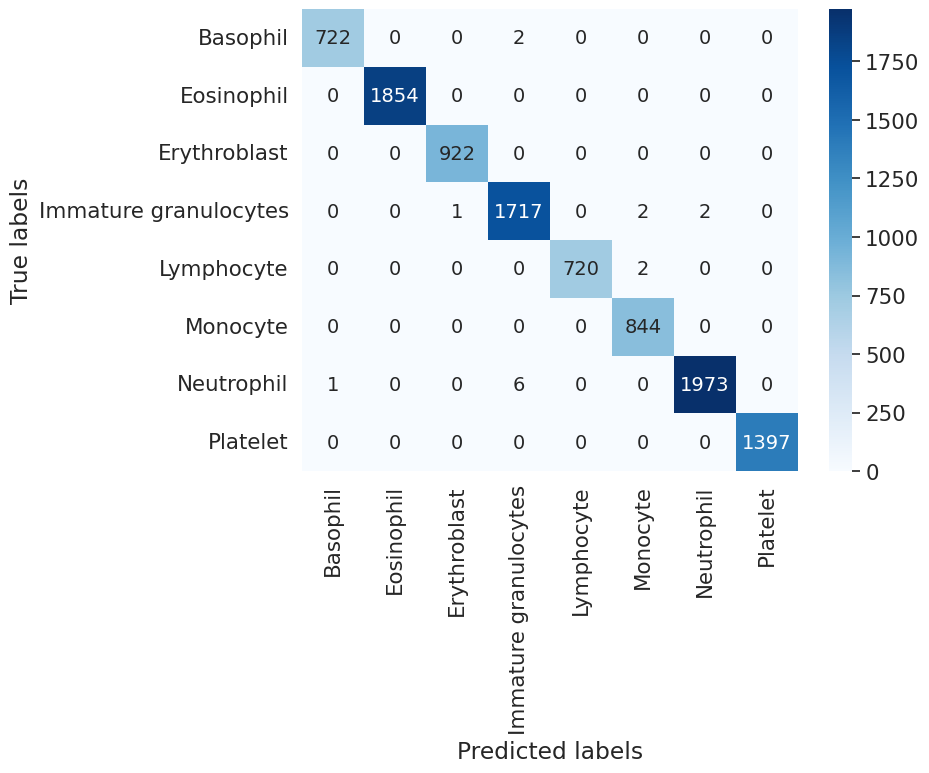

AUC-ROC Score (macro): 1.0000
Evaluating validation set...
Accuracy: 0.9933
Precision: 0.9933
Recall: 0.9933
F1 Score: 0.9933


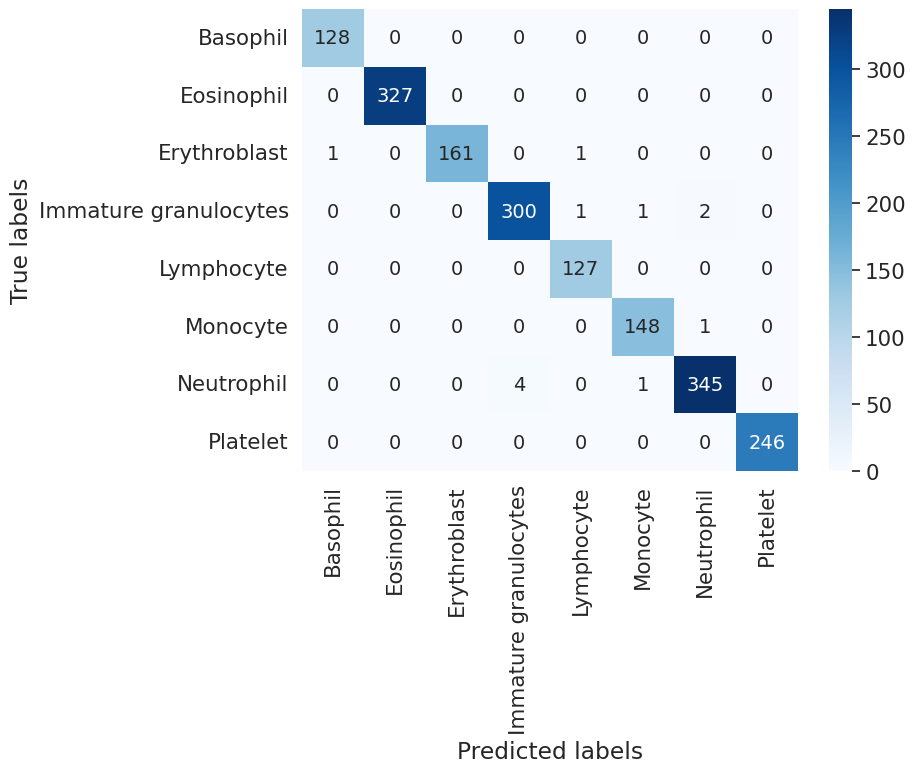

AUC-ROC Score (macro): 0.9999


(array([3, 6, 6, ..., 1, 0, 2]), array([3, 6, 6, ..., 1, 0, 2]))

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Generatore per il caricamento e ridimensionamento dei dati
def data_generator(X, y, batch_size, target_size=(380, 380)):
    dataset_size = len(X)
    for i in range(0, dataset_size, batch_size):
        batch_X = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        batch_X_resized = tf.image.resize(batch_X, target_size).numpy()
        yield batch_X_resized, batch_y

# Funzione per predire in batch con un generatore
def predict_with_generator(model, generator, steps):
    predictions = []
    for i, (batch_X, _) in enumerate(generator):
        batch_predictions = model.predict(batch_X, verbose=0)
        predictions.append(batch_predictions)
        if i >= steps - 1:  # Ferma dopo il numero richiesto di batch
            break
    return np.vstack(predictions)

# Funzione per calcolare metriche e mostrare confusion matrix
def evaluate_model_with_generator(model, X, y, class_labels, batch_size=32):
    # Configura il generatore
    generator = data_generator(X, y, batch_size)
    steps = len(X) // batch_size + int(len(X) % batch_size != 0)

    # Predizioni usando il generatore
    y_pred = predict_with_generator(model, generator, steps)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_true_classes = np.argmax(y, axis=-1)

    # Calcolo delle metriche
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    # AUC-ROC (se applicabile)
    n_classes = len(class_labels)
    y_true_bin = tf.keras.utils.to_categorical(y_true_classes, num_classes=n_classes)
    roc_auc = roc_auc_score(y_true_bin, y_pred, average="macro", multi_class="ovr")
    print(f"AUC-ROC Score (macro): {roc_auc:.4f}")

    return y_pred_classes, y_true_classes

# Carica il modello salvato
model = tf.keras.models.load_model('FuoriDiTesta_FT_99.33.keras')

# Dizionario delle etichette
label_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}
class_labels = list(label_dict.values())

# Valutazione del training set
print("Evaluating training set...")
evaluate_model_with_generator(model, X_train, y_train, class_labels, batch_size=32)

# Valutazione del validation set
print("Evaluating validation set...")
evaluate_model_with_generator(model, X_val, y_val, class_labels, batch_size=32)
